In [507]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import psycopg2

C:\Users\nurislamov\PycharmProjects\applied_hydrogeology\venv\lib\site-packages\pandas\io\sql.py:758: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


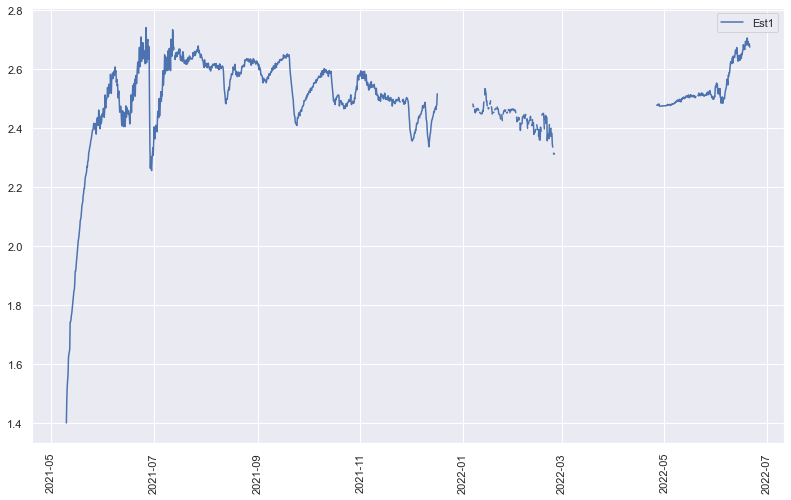

In [544]:
conn = psycopg2.connect(database="****", user="***",
    password="***", host="****", port=5432)
cur = conn.cursor()
sql = "SELECT date, w1.water_depth as wd1,w2.water_depth as wd2  FROM (select * from \"Automatic_logs\" where well_id=177004) w1\
       full outer join (select * from  \"Automatic_logs\" where well_id=177000 and (date::date<='16-12-2021' or date::date>'01-06-2022')) w2 using (date) order by date"
dat = pd.read_sql_query(sql, conn)

dat['date'] = pd.to_datetime(dat['date'], format='%Y-%m-%d %H:%M:%S')
data = dat.set_index('date')
data = data.asfreq('6H')
data = data.sort_index()
fig, axs=plt.subplots(1,1,figsize=(12,8),sharex=True,sharey=True)
axs.plot(data.index,data['wd2'],label='Est1')
axs.legend()

plt.xticks(rotation='vertical')
plt.show()

In [536]:
precipNotNan = data.dropna()

In [537]:
xTrain = precipNotNan[['wd1']]
yTrain = precipNotNan[['wd2']].values.flatten()
scaler = StandardScaler().fit(xTrain.values)
xTrainScaled = scaler.transform(xTrain.values)
regr = MLPRegressor(max_iter=50000,tol=0.00000001, random_state=123).fit(xTrainScaled, yTrain)
#test
xTest = data[['wd1']].dropna()
xTestScaled = scaler.transform(xTest.values)

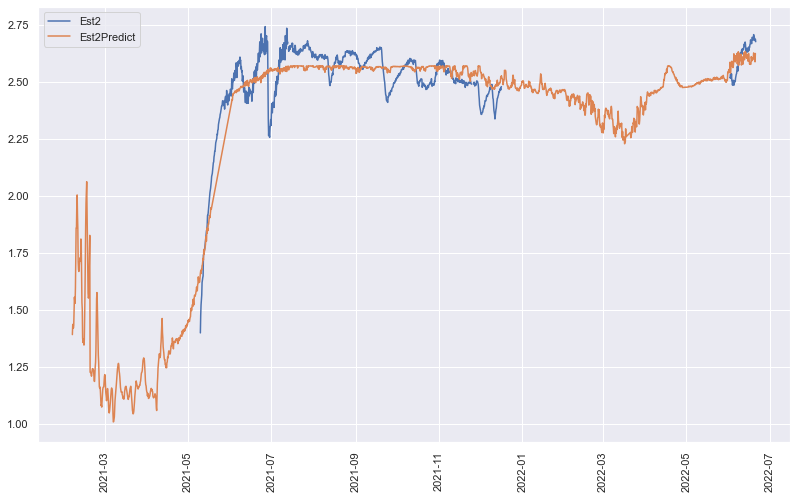

In [540]:
yPredict = regr.predict(xTestScaled)
fig, ax=plt.subplots(figsize=(12,8),sharex=True,sharey=True)
ax.plot(data.index,data['wd2'],label='Est2')
ax.plot(xTest.index,yPredict,label='Est2Predict')
plt.legend()
plt.xticks(rotation='vertical')
plt.show()

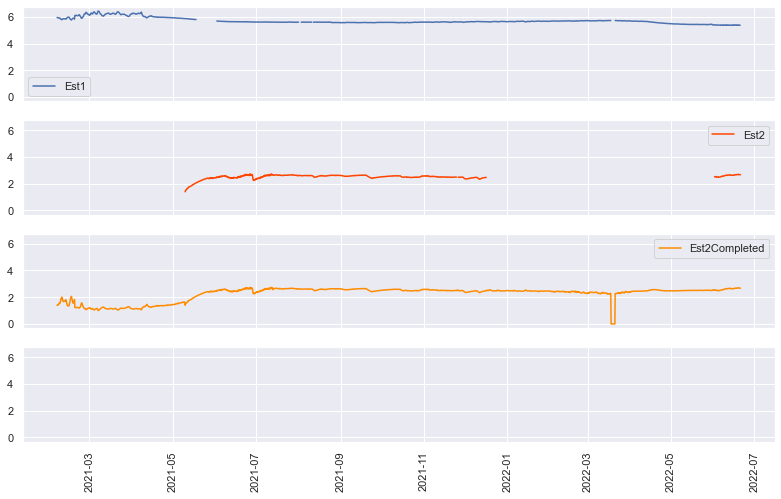

In [542]:
data['Est2Completed'] = 0
#fill the new column with original and predicted values for Est2
for index, row in data.iterrows():
    if np.isnan(row['wd2']) and ~np.isnan(row['wd1']):
        rowScaled = scaler.transform([[row['wd1']]])
        data.loc[index,['Est2Completed']] = regr.predict(rowScaled)
    elif ~np.isnan(row['wd2']):
        data.loc[index,['Est2Completed']] = row['wd2']
    else:
        row['Est2Completed'] = np.nan
#show original and filled values
fig, axs=plt.subplots(4,1,figsize=(12,8),sharex=True,sharey=True)
axs[0].plot(data.index,data['wd1'],label='Est1')
axs[0].legend()
axs[1].plot(data.index,data['wd2'],label='Est2',color='orangered')
axs[1].legend()
axs[2].plot(data.index,data['Est2Completed'],label='Est2Completed',color='darkorange')
axs[2].legend()
plt.xticks(rotation='vertical')
plt.show()
data.to_csv('177000.csv')